In [2]:
import shutil

import matplotlib.pyplot as plt
import pandas as pd

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.regularizers import l1_l2
from tensorflow import keras
import tensorflow as tf
from tqdm import tqdm
import warnings
import os

from functions import *

pd.set_option('display.float_format', '{:.6f}'.format)

2023-10-08 18:31:50.965548: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-08 18:31:53.640853: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Data

In [3]:
df = pd.read_csv(df_path, index_col="Unnamed: 0").T

In [4]:
print(df)

              1050608  130468   3589405  355102   1081058  189592   354275   \
E000823.1.8         0        0        0        0        0        0        0   
E000823.2.6         0        0        0        0        0        0        0   
E000823.4.0         0        0        0        0        0        0        0   
E000823.5.0         0        0        0        0        0        0        0   
E000823.5.7         0        0        0        0        0        0        0   
...               ...      ...      ...      ...      ...      ...      ...   
E014086.30.4        0        0        0        0        0        1       11   
E014086.32.4        0        0        0        0        0        0       13   
E014086.33.5        0        0        0        0        0        0        0   
E014086.34.4        0        0        0        0        0        1        0   
E014086.36.0        0        0        0        0        0        0        0   

              4327628  326749   183857   ...  31792

## Preprocessing


In [40]:
zero_values_percentage_cutoff = 0.5 # no more than x% of data can be zeros
smoothing_window_size = 5
df = preprocess(zero_values_percentage_cutoff=zero_values_percentage_cutoff, smoothing_window_size=smoothing_window_size)

2023-10-08 18:51:11.533462: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-08 18:51:11.854310: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-08 18:51:11.857001: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-08 18:51:11.874114: I tensorflow/core/platform/cpu_featu

In [41]:
df

,659361,364179,3439402,181155,302746,4473763,175535,3887769,585227,189384,...,359650,130663,922761,3304236,584137,193233,4334711,196664,583117,354850
E000823.1.8,0.000000,0.000221,0.195402,0.002871,0.000000,0.252560,0.009901,0.145455,0.000000,0.087963,...,0.000000,0.237179,0.000433,0.102041,0.000000,0.042448,0.507874,0.063005,0.010525,0.043189
E000823.2.6,0.052888,0.000273,0.137931,0.012440,0.000000,0.204778,0.007921,0.109091,0.000000,0.120370,...,0.000000,0.173077,0.000939,0.163265,0.000067,0.037373,0.437008,0.056729,0.010298,0.019934
E000823.4.0,0.052888,0.000256,0.160920,0.013397,0.000000,0.443686,0.019802,0.072727,0.000000,0.074074,...,0.000000,0.179487,0.000987,0.183673,0.000067,0.053983,0.389764,0.069040,0.032819,0.013289
E000823.5.0,0.052888,0.000204,0.103448,0.053589,0.000000,0.375427,0.019802,0.054545,0.000000,0.064815,...,0.000000,0.166667,0.003901,0.183673,0.000089,0.048139,0.338583,0.052505,0.030623,0.000000
E000823.5.7,0.052888,0.000204,0.195402,0.053589,0.046985,0.382253,0.021782,0.054545,0.112668,0.078704,...,0.000000,0.147436,0.080911,0.122449,0.053025,0.044909,0.287402,0.054919,0.083269,0.013289
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E014086.22.5,0.054103,0.115345,0.172414,0.001435,0.058205,0.044369,0.033663,0.418182,0.361913,0.402778,...,0.339315,0.115385,0.000024,0.428571,0.045208,0.085205,0.177165,0.131201,0.328075,0.289037
E014086.23.4,0.084802,0.145123,0.183908,0.006699,0.062412,0.088737,0.035644,0.545455,0.462215,0.532407,...,0.428222,0.115385,0.000747,0.489796,0.061491,0.110889,0.212598,0.174412,0.407474,0.209302
E014086.24.5,0.094833,0.161664,0.379310,0.009091,0.105189,0.143345,0.067327,0.563636,0.874141,0.800926,...,0.644372,0.205128,0.000747,0.489796,0.084206,0.133959,0.283465,0.297284,0.596487,0.325581
E014086.26.4,0.059574,0.153453,0.597701,0.009091,0.183029,0.334471,0.071287,0.709091,0.932949,0.828704,...,0.712072,0.243590,0.000747,0.408163,0.071408,0.196555,0.334646,0.417139,0.741297,0.365449


## Features and targets

In [42]:
seq_length = 10
cutoff = 411

X_sequences, y_targets = cut_to_sequences(feats_df=df, seq_length=seq_length)

y_targets = pd.DataFrame(y_targets)
y_targets.columns = df.columns

X_sequences_train = X_sequences[:cutoff]
y_targets_train = y_targets[:cutoff]

X_sequences_test = X_sequences[cutoff:]
y_targets_test = y_targets[cutoff:]

print(f"Length of data: {len(df)}")
print(f"Total sequences: {len(X_sequences)}")
print(f"Train sequences: {len(X_sequences_train)}")
print(f"Test sequences: {len(X_sequences_test)}")

Length of data: 516
Total sequences: 506
Train sequences: 411
Test sequences: 95


In [43]:
y_targets

,659361,364179,3439402,181155,302746,4473763,175535,3887769,585227,189384,...,359650,130663,922761,3304236,584137,193233,4334711,196664,583117,354850
0,0.000000,0.000238,0.229885,0.000957,0.120617,0.088737,0.005941,0.400000,0.264908,0.212963,...,0.428222,0.083333,0.008862,0.142857,0.104264,0.012304,0.161417,0.033675,0.274139,0.119601
1,0.000000,0.000290,0.206897,0.000957,0.123422,0.092150,0.005941,0.418182,0.253641,0.203704,...,0.530179,0.102564,0.005153,0.122449,0.136026,0.014765,0.169291,0.038503,0.294871,0.122924
2,0.024316,0.000307,0.206897,0.000478,0.118513,0.119454,0.005941,0.400000,0.256389,0.217593,...,0.636215,0.102564,0.005539,0.122449,0.129794,0.017379,0.177165,0.043935,0.315672,0.049834
3,0.024620,0.000256,0.195402,0.000478,0.117111,0.119454,0.007921,0.381818,0.181918,0.175926,...,0.663948,0.089744,0.005587,0.102041,0.139733,0.025531,0.165354,0.042728,0.278914,0.066445
4,0.040122,0.000221,0.172414,0.000478,0.093969,0.143345,0.015842,0.218182,0.044243,0.175926,...,0.665579,0.096154,0.002264,0.102041,0.106095,0.043064,0.129921,0.059264,0.205310,0.049834
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.054103,0.115345,0.172414,0.001435,0.058205,0.044369,0.033663,0.418182,0.361913,0.402778,...,0.339315,0.115385,0.000024,0.428571,0.045208,0.085205,0.177165,0.131201,0.328075,0.289037
502,0.084802,0.145123,0.183908,0.006699,0.062412,0.088737,0.035644,0.545455,0.462215,0.532407,...,0.428222,0.115385,0.000747,0.489796,0.061491,0.110889,0.212598,0.174412,0.407474,0.209302
503,0.094833,0.161664,0.379310,0.009091,0.105189,0.143345,0.067327,0.563636,0.874141,0.800926,...,0.644372,0.205128,0.000747,0.489796,0.084206,0.133959,0.283465,0.297284,0.596487,0.325581
504,0.059574,0.153453,0.597701,0.009091,0.183029,0.334471,0.071287,0.709091,0.932949,0.828704,...,0.712072,0.243590,0.000747,0.408163,0.071408,0.196555,0.334646,0.417139,0.741297,0.365449


## The model

In [44]:
import tensorflow as tf
import keras.backend as K

class mae_ignore_zeros(tf.keras.losses.Loss):
    
    def __init__(self, false_positives_penalty_factor, name='mae_ignore_zeros', reduction=tf.keras.losses.Reduction.AUTO,):
        super(mae_ignore_zeros, self).__init__()
        self.false_positives_penalty_factor = false_positives_penalty_factor
        self.name = name
        

    def call(self, y_true, y_pred):
        
        y_true = tf.cast(y_true, tf.float64)
        y_pred = tf.cast(y_pred, tf.float64)
        
        false_positives_penalty_factor = tf.constant(self.false_positives_penalty_factor, dtype=tf.float64)
        
        # Find indices where y_true is not zero
        non_zero_indices = tf.where(tf.not_equal(y_true, 0))
      
        y_true = tf.reshape(y_true, (-1, 1))
        y_pred = tf.reshape(y_pred, (-1, 1))
        
        # Gather the non-zero elements from y_true and y_pred using the indices
        y_true_non_zero = tf.gather_nd(y_true, non_zero_indices)
        y_pred_non_zero = tf.gather_nd(y_pred, non_zero_indices)

        y_true_non_zero = tf.cast(y_true_non_zero, tf.float64)
        y_pred_non_zero = tf.cast(y_pred_non_zero, tf.float64)

        # Calculate MAE on the non-zero elements
        mae_non_zero = tf.reduce_mean(tf.abs(y_pred_non_zero - y_true_non_zero))

        # Find indices where y_true is zero
        zero_indices = tf.where(tf.equal(y_true, 0))

        # Gather the corresponding y_pred values
        y_pred_zero = tf.gather_nd(y_pred, zero_indices)

        y_pred_zero = tf.cast(y_pred_zero, tf.float64)

        # Calculate the average of false positives
        false_positives_avg = tf.reduce_mean(y_pred_zero)
        
        # Combine the MAE on non-zero elements with the average of false positives
        mae_ignore_zeros = (mae_non_zero + (false_positives_avg * false_positives_penalty_factor)) * 100 
    
        return mae_ignore_zeros


In [45]:
def fetch_model():

    reg = 1e-8
    
    n_feats = len(df.columns)
    
    model = Sequential()
    model.add(keras.Input(shape=(seq_length, n_feats)))
    model.add(keras.layers.LSTM(1024, return_sequences=False, activation='relu'))
    model.add(keras.layers.Dense(512, activation="relu", kernel_regularizer=l1_l2(reg)))
    model.add(keras.layers.Dense(128, activation="relu", kernel_regularizer=l1_l2(reg)))
    model.add(keras.layers.Dense(1, activation="relu"))
    
    model.compile(optimizer="Adam", loss=loss, metrics=["mae", "mape"])
    
    return model

In [46]:
def compile_model(model, loss):
    model.compile(optimizer="Adam", loss=loss, metrics=["mae", "mape"])
    return model

In [47]:
#model = fetch_model()
#
#model.summary()
#
#model.save("/home/nate/temp/test_model_save.model")

## Individual model testbench

In [48]:
y_true = tf.constant([0])
y_pred = tf.constant([1])

loss = mae_ignore_zeros(false_positives_penalty_factor=0.1)
loss.call(y_true, y_pred)

<tf.Tensor: shape=(), dtype=float64, numpy=nan>

In [49]:
target_taxa = 181155

plot=False

if plot is True:
    plot_a_taxa_sequence(y_targets_train[target_taxa], title=f"Train sequence for taxa_idx {target_taxa}", color="blue")

In [50]:
n_epochs = 15

loss = mae_ignore_zeros(false_positives_penalty_factor=0.1)
model = fetch_model()
model = compile_model(model, "mae")

model.fit(x=X_sequences_train, y=y_targets_train[target_taxa], validation_split=0.05, epochs=n_epochs, verbose=1)

Epoch 1/15
13/13 [==============================] - 2s 27ms/step - loss: 7.1339 - mae: 0.0618 - mape: 4943067.0000 - val_loss: 5.2362 - val_mae: 0.2329 - val_mape: 95.2381
Epoch 2/15
13/13 [==============================] - 0s 15ms/step - loss: 3.8870 - mae: 0.0407 - mape: 93.3333 - val_loss: 2.8169 - val_mae: 0.2329 - val_mape: 95.2381
Epoch 3/15
13/13 [==============================] - 0s 14ms/step - loss: 1.9822 - mae: 0.0407 - mape: 93.3333 - val_loss: 1.4984 - val_mae: 0.2329 - val_mape: 95.2381
Epoch 4/15
13/13 [==============================] - 0s 15ms/step - loss: 0.9817 - mae: 0.0407 - mape: 93.3333 - val_loss: 0.8403 - val_mae: 0.2329 - val_mape: 95.2381
Epoch 5/15
13/13 [==============================] - 0s 14ms/step - loss: 0.4935 - mae: 0.0407 - mape: 93.3333 - val_loss: 0.5285 - val_mae: 0.2329 - val_mape: 95.2381
Epoch 6/15
13/13 [==============================] - 0s 15ms/step - loss: 0.2723 - mae: 0.0407 - mape: 111.2002 - val_loss: 0.4116 - val_mae: 0.2329 - val_mape: 

3/3 [==============================] - 0s 3ms/step


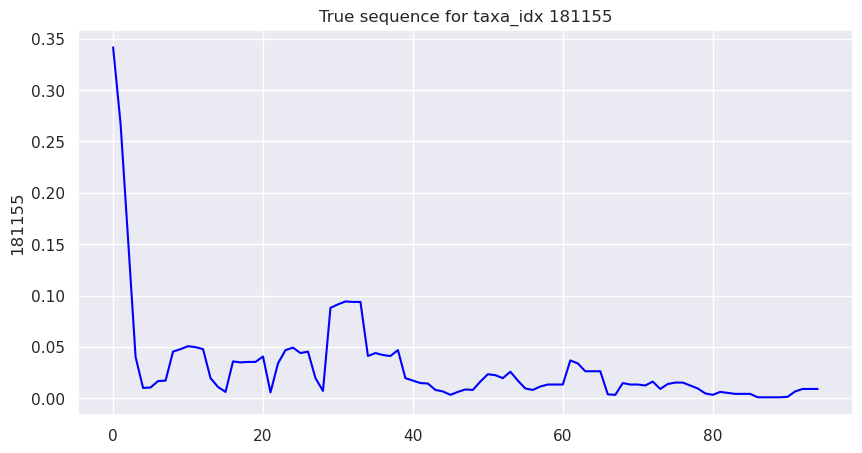

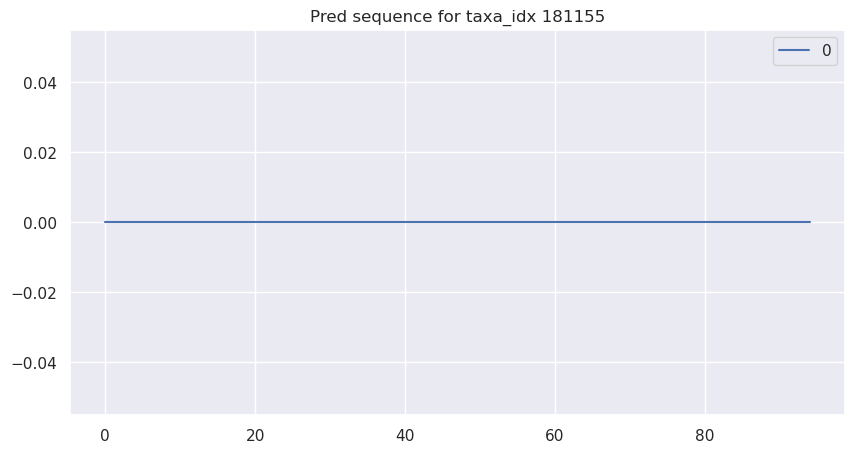

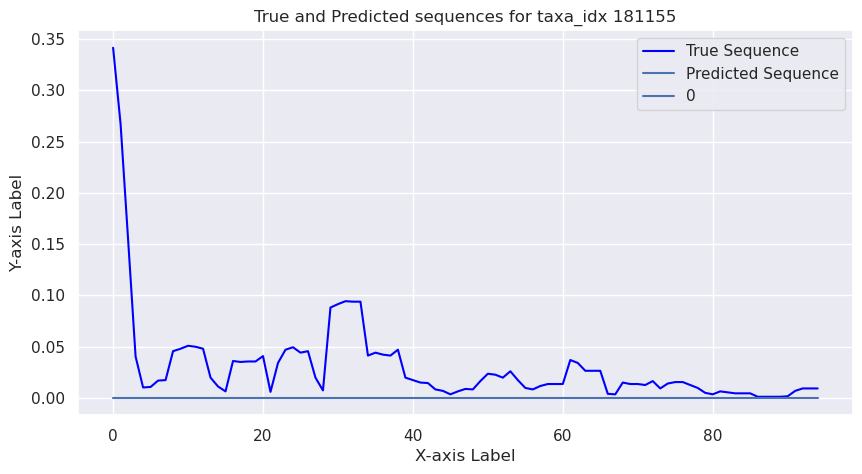

In [51]:
y_pred = model.predict(X_sequences_test)

true_sequence = y_targets_test[target_taxa].reset_index(drop=True)
pred_sequence = y_pred

sequence_comparisson_graphs(true_sequence, pred_sequence, target_taxa)

## The Ensemble

In [52]:
class ensemble():
    
    def __init__(self, ensemble_name, loss, overwrite_on_train=False):
        
        self.models_out_dir = f"{root_dir}/models/{ensemble_name}"
        self.overwrite_on_train = overwrite_on_train
        self.loss = loss

        
    def train(self, X_sequences_train, y_targets_train, n_epochs):
        
        if not os.path.exists(self.models_out_dir):
            os.mkdir(self.models_out_dir)
        else:
            if self.overwrite_on_train is False:
                raise Exception("This model dir already exists")
            else:
                print("Overwriting an existing model dir")
                shutil.rmtree(self.models_out_dir)
                os.mkdir(self.models_out_dir)
                
        for taxa_idx in tqdm(y_targets_train.columns, desc="Training models"):
            
            model = fetch_model()
            model = compile_model(model, loss)
            y_targets = y_targets_train[taxa_idx]
            model.fit(x=X_sequences_train, y=y_targets, validation_split=0.05, epochs=n_epochs, verbose=0)
            
            model.save(f"{self.models_out_dir}/{taxa_idx}.model")
            
            del model
            
    
    def load(self):
        
        self.model_dic = {}

        for model_dir in tqdm(os.listdir(self.models_out_dir), desc="Loading the models"):
            taxa_idx = int(model_dir.replace(".model", ""))
            
            if isinstance(loss, mae_ignore_zeros):
                model = tf.keras.models.load_model(f"{self.models_out_dir}/{taxa_idx}.model", compile=False)
                model = compile_model(model, loss)
            else:
                model = tf.keras.models.load_model(f"{self.models_out_dir}/{taxa_idx}.model")
                 
            self.model_dic[taxa_idx] = model
    
         
    def predict(self, X_sequences):
        
        self.load()
        
        n_sequences = len(X_sequences)
        
        pred_list = []
        for taxa_idx in tqdm(self.model_dic.keys(), desc="Predicting values"):
            model = self.model_dic[taxa_idx]
            pred_list.append(model.predict(X_sequences, verbose=0).reshape(n_sequences,))
            del(model)
            
        pred_df = pd.DataFrame(pred_list).T
            
        return pred_df

In [53]:
# Tensorflow does not play nice with my Linux machine, thus I am filtering out its warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

loss = mae_ignore_zeros(false_positives_penalty_factor=0.1)

model_ensemble = ensemble(ensemble_name="test_ensemble", loss="mae", overwrite_on_train=True)

In [54]:
model_ensemble.train(X_sequences_train=X_sequences_train, y_targets_train=y_targets_train, n_epochs=15)

Overwriting an existing model dir


Training models: 100%|██████████| 202/202 [35:44<00:00, 10.62s/it] 


In [55]:
y_test_df = pd.DataFrame(y_targets_test)
y_test_df = y_test_df.reset_index(drop=True)
y_test_df

,659361,364179,3439402,181155,302746,4473763,175535,3887769,585227,189384,...,359650,130663,922761,3304236,584137,193233,4334711,196664,583117,354850
0,0.058055,0.000324,0.022989,0.341627,0.513324,0.000000,0.003960,0.018182,0.019236,0.046296,...,0.011419,0.000000,0.097334,0.000000,0.000558,0.000461,0.000000,0.005794,0.027115,0.043189
1,0.066869,0.000307,0.068966,0.266986,0.513324,0.003413,0.003960,0.036364,0.020335,0.097222,...,0.017945,0.006410,0.093794,0.000000,0.000536,0.001692,0.000000,0.024019,0.087434,0.106312
2,0.068085,0.000290,0.091954,0.154545,0.394811,0.023891,0.001980,0.036364,0.025007,0.097222,...,0.022023,0.006410,0.020469,0.000000,0.000514,0.004460,0.027559,0.035003,0.185438,0.106312
3,0.068997,0.000290,0.149425,0.040191,0.152875,0.023891,0.001980,0.036364,0.033800,0.180556,...,0.027732,0.032051,0.032196,0.040816,0.000491,0.005691,0.035433,0.061316,0.275474,0.172757
4,0.037690,0.000017,0.229885,0.010048,0.000000,0.047782,0.001980,0.127273,0.078593,0.203704,...,0.051387,0.051282,0.018663,0.040816,0.000089,0.008305,0.039370,0.075075,0.478362,0.176080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,0.054103,0.115345,0.172414,0.001435,0.058205,0.044369,0.033663,0.418182,0.361913,0.402778,...,0.339315,0.115385,0.000024,0.428571,0.045208,0.085205,0.177165,0.131201,0.328075,0.289037
91,0.084802,0.145123,0.183908,0.006699,0.062412,0.088737,0.035644,0.545455,0.462215,0.532407,...,0.428222,0.115385,0.000747,0.489796,0.061491,0.110889,0.212598,0.174412,0.407474,0.209302
92,0.094833,0.161664,0.379310,0.009091,0.105189,0.143345,0.067327,0.563636,0.874141,0.800926,...,0.644372,0.205128,0.000747,0.489796,0.084206,0.133959,0.283465,0.297284,0.596487,0.325581
93,0.059574,0.153453,0.597701,0.009091,0.183029,0.334471,0.071287,0.709091,0.932949,0.828704,...,0.712072,0.243590,0.000747,0.408163,0.071408,0.196555,0.334646,0.417139,0.741297,0.365449


In [56]:
y_pred_df = model_ensemble.predict(X_sequences_test)
y_pred_df = y_pred_df.reset_index(drop=True)
y_pred_df.columns = y_test_df.columns

Predicting values: 100%|██████████| 202/202 [00:26<00:00,  7.68it/s]


In [57]:
y_pred_df

,659361,364179,3439402,181155,302746,4473763,175535,3887769,585227,189384,...,359650,130663,922761,3304236,584137,193233,4334711,196664,583117,354850
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.077057,0.000000,0.036313,...,0.000000,0.000000,0.000000,0.002996,0.000000,0.000000,0.000000,0.000000,0.000000,0.026457
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.143106,0.000000,0.086524,...,0.000000,0.000000,0.000000,0.038388,0.000000,0.000000,0.000000,0.000000,0.000000,0.037679
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.209715,0.000000,0.137544,...,0.000000,0.000000,0.000000,0.069428,0.000000,0.000000,0.000000,0.000000,0.000000,0.046766
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.172911,0.000000,0.133166,...,0.002792,0.000000,0.000000,0.083759,0.000000,0.000000,0.000000,0.000000,0.000000,0.052047
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.130270,0.000000,0.134935,...,0.035991,0.000000,0.000000,0.088712,0.000000,0.000000,0.000000,0.000000,0.000000,0.065464
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,0.000000,0.000000,0.155774,0.000000,0.000000,0.160695,0.063423,0.385149,0.000000,0.162761,...,0.136250,0.130002,0.000000,0.217141,0.000000,0.000000,0.115566,0.000000,0.000000,0.272447
91,0.000000,0.000000,0.180731,0.000000,0.000000,0.187715,0.063690,0.450582,0.000000,0.189480,...,0.171246,0.166240,0.000000,0.256253,0.000000,0.000000,0.152435,0.000000,0.000000,0.288343
92,0.000000,0.000000,0.211026,0.000000,0.000000,0.229143,0.075683,0.537642,0.000000,0.232244,...,0.211798,0.202968,0.000000,0.316340,0.000000,0.000000,0.183979,0.000000,0.000000,0.308457
93,0.000000,0.000000,0.284614,0.000000,0.000000,0.286595,0.108502,0.659638,0.000000,0.287300,...,0.328939,0.262566,0.000000,0.366189,0.000000,0.000000,0.237404,0.000000,0.000000,0.337015


In [58]:
non_predicted_cols = [col for col in y_pred_df.columns if all(y_pred_df[col] == 0.0)]
n_non_predicted_cols = len(non_predicted_cols)

print(f"Total taxa not predicted: {n_non_predicted_cols}, {(n_non_predicted_cols/len(y_test_df.columns)) * 100}% of all taxa")

Total taxa not predicted: 109, 53.960396039603964% of all taxa


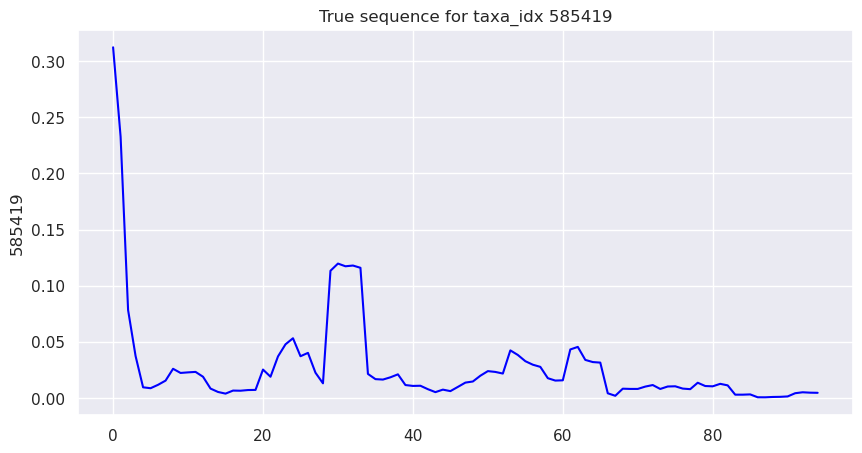

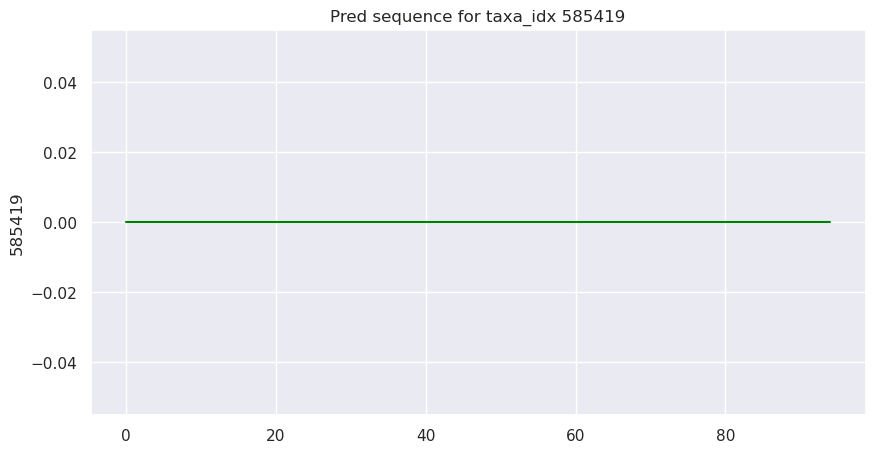

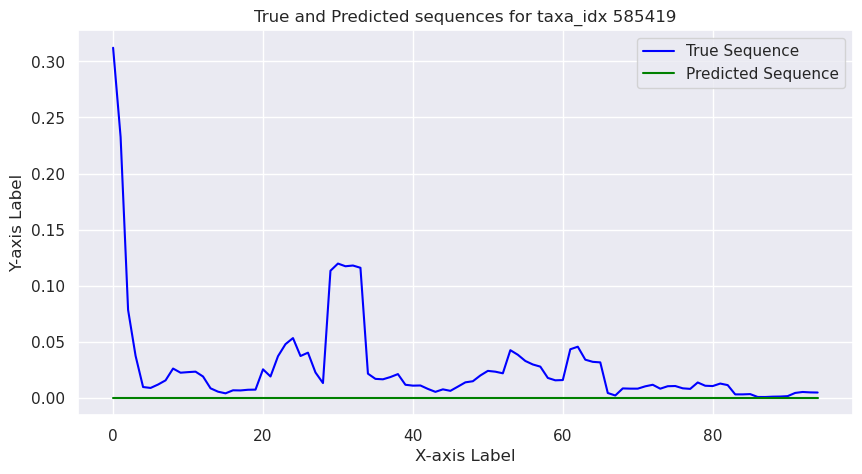

In [59]:
target_taxa = 585419

true_sequence = y_test_df[target_taxa].reset_index(drop=True)
pred_sequence = y_pred_df[target_taxa]

sequence_comparisson_graphs(true_sequence, pred_sequence, target_taxa)

In [60]:
def calculate_percentage_errors(y_pred_df, y_test_df):
    # Description: calculate percentage errors on on all taxa

    y_pred_df = y_pred_df.reset_index(drop=True)
    y_test_df = y_test_df.reset_index(drop=True)

    errors_df = []
    for col in y_pred_df.columns:
        errors = abs((y_pred_df[col] - y_test_df[col]) / (y_pred_df[col] + 1e-10))
        errors_df.append(errors)

    errors_df = pd.concat(errors_df, axis=1)

    return errors_df

In [61]:
errors_df = calculate_percentage_errors(y_pred_df, y_test_df)
errors_df.describe()

,659361,364179,3439402,181155,302746,4473763,175535,3887769,585227,189384,...,359650,130663,922761,3304236,584137,193233,4334711,196664,583117,354850
count,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,...,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000
mean,253271473.182213,1317367453.079343,59286146.280367,307731046.004672,717797288.711204,30896353.560803,11881188.787373,0.510294,1896327768.609658,0.528849,...,5409118.833416,10121458.533232,542274961.613344,0.492849,322817044.790088,2482717835.038468,15748032.112110,2075329515.219309,2730671420.600825,0.774384
std,322848336.889615,2502608736.516109,301725895.934242,480815912.428739,888331510.380047,161552180.701777,52343319.327802,0.375748,2068665787.257126,0.461935,...,31107489.563940,62245177.654517,884636828.901074,0.374901,402173072.411843,2556198009.695094,76918103.377723,2035874578.329988,2587763375.163496,0.749732
min,0.000000,170351.944848,0.017581,9569377.862666,0.000000,0.000000,0.000000,0.006421,0.000000,0.008346,...,0.012025,0.000000,0.000000,0.021112,223358.867715,0.000000,0.000000,2414001.174770,226336.514112,0.000390
25%,6079027.274459,3151510.979694,0.252714,83732056.298325,129733518.604478,0.256029,0.363144,0.201596,134652375.228854,0.229133,...,0.175895,0.313085,10113901.663795,0.199716,10497866.782623,489849270.605304,0.202274,758599869.171545,1027341437.553269,0.248264
50%,36474163.646756,142073522.003493,0.525353,153110045.802652,483870961.281565,0.496399,0.855132,0.504336,1602088464.457585,0.384506,...,0.399792,0.520630,79225563.033058,0.407431,109892562.915971,1159643171.228884,0.603053,1285455625.565148,1804581027.013045,0.546031
75%,449848018.309994,1380872864.940427,0.909355,385167458.972295,1020336592.267648,0.824630,1.701083,0.748446,2829073883.634792,0.751417,...,0.910312,1.000000,531581855.305395,0.726131,560854116.833342,4609350907.391201,1.094215,2799034362.146083,3054184921.424060,0.964877
max,1115501504.863297,9999999866.485682,2298850544.019697,3416267896.971664,5133239763.160954,1365187695.083370,356435638.805430,1.904427,9329485997.999146,2.448646,...,220228382.051479,512820505.973625,3344811764.526360,2.550241,1445355232.986282,9301753182.483143,472440938.574127,9999999866.485682,9999999866.485682,3.596981


In [62]:
def percentile_graph(errors_df, label, y_top_lim=3, step=0.1):
    # Description: Solves the problem of representing accuracy on a lot of different taxa in one single graph
    # Produces a graph of percentiles on medians in (y_pred - y_true) on taxa sequences


    # hardcoded stuff
    percentile_range = np.arange(0, 101)
    x_ticks_range = range(0, 110, 10)

    median_errors = errors_df.median()
    median_error_percentiles = np.percentile(median_errors, percentile_range)

    sns.set()
    plt.figure(figsize=(8, 6))
    sns.lineplot(median_error_percentiles)
    plt.title(f"Percentiles of median absolute errors {label}")
    plt.xticks(x_ticks_range)
    plt.yticks(np.arange(0, float(y_top_lim + step), step))
    plt.ylim(0, y_top_lim)

    percentile_50 = median_error_percentiles[50]
    sns.lineplot([percentile_50 for _ in range(len(percentile_range))], color="red", label="50 percentile line")

    plt.show()

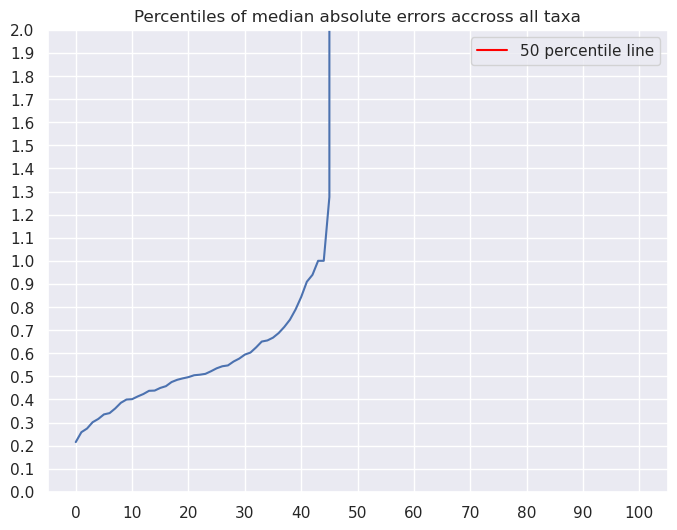

In [63]:
percentile_graph(errors_df, "accross all taxa", y_top_lim=2)

In [38]:
only_predicted_errors = errors_df[errors_df.columns[~(errors_df.columns.isin(non_predicted_cols))]]
only_predicted_errors.describe()

,865469,585419,262095,583656,560336,182854,559527,589071,1078587,323231,...,1111294,2415144,351231,360015,3426658,312140,484304,301578,577170,583117
count,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,...,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000
mean,63851335.787397,0.948587,0.781024,23798656.318203,0.394819,0.371466,0.621975,1946738.456589,0.536843,0.842157,...,256152387.068238,0.534439,15256223.992534,22690130.782187,0.411220,0.362145,2606516.902812,0.426219,17380233.724233,305437552.963522
std,300730813.950717,1.972904,0.924958,116176577.413596,0.310720,0.315127,0.303368,8641659.553866,0.682488,0.925260,...,739978484.736736,0.423877,85169157.605479,209857605.436422,0.383550,0.288424,3869515.544681,0.326395,103894923.901771,1119183025.894830
min,0.008560,0.041491,0.011558,0.008386,0.006556,0.007442,0.009183,0.004466,0.004137,0.002267,...,0.022117,0.000700,0.010317,0.016420,0.006735,0.001575,0.044213,0.008685,0.004555,0.005636
25%,0.268187,0.598074,0.433021,0.238993,0.130742,0.164537,0.378071,0.384849,0.172536,0.268342,...,0.486669,0.207747,0.187316,0.169250,0.146235,0.160188,0.982522,0.196163,0.288374,0.398206
50%,0.643161,0.822863,0.648999,0.623259,0.310312,0.289972,0.662250,0.958290,0.354128,0.615881,...,0.892777,0.443068,0.561331,0.402767,0.304986,0.292359,0.999648,0.371212,0.729925,0.662987
75%,1.377828,0.901514,0.840979,1.108896,0.605501,0.478271,0.875497,1.070189,0.752631,0.914970,...,1.103144,0.739524,0.998637,0.823556,0.557829,0.511942,4901960.718866,0.579620,1.153640,1.884267
max,1800473909.610384,19.678633,5.429093,783528975.786712,1.087093,2.082193,1.098943,43058569.668811,4.961623,4.845123,...,3618290210.139949,1.866189,640617892.400946,2045120265.726877,2.551562,1.089678,13165265.930667,2.076116,841591361.541166,7208365301.431262


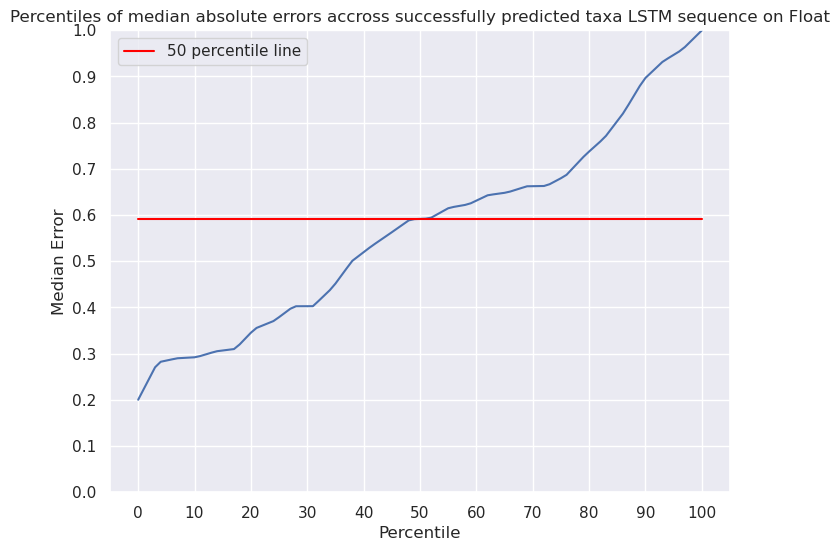

In [69]:
percentile_graph(only_predicted_errors, "accross successfully predicted taxa LSTM sequence on Float", y_top_lim=1)

In [64]:
medians = [np.median(only_predicted_errors[col]) for col in only_predicted_errors.columns]

<Axes: ylabel='Count'>

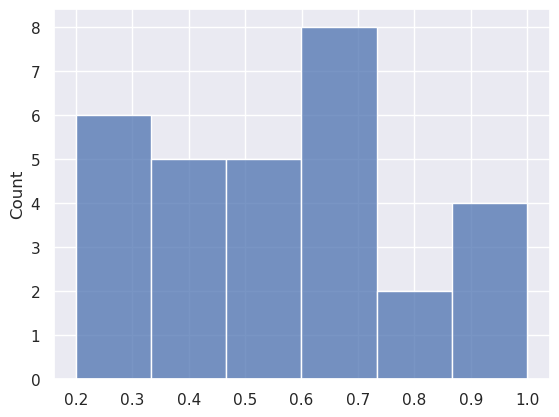

In [65]:
sns.histplot(medians)

In [66]:
predicted_taxa = only_predicted_errors.columns